<a href="https://colab.research.google.com/github/Dzy00/CHL5230-datathon4/blob/main/datathon4_Rose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
# read the data
data = pd.read_csv('datathon4.csv')
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
print(data.shape)

(91713, 186)


In [ ]:
# Check how many patients there are
data['patient_id'].unique().shape

(91713,)

In [ ]:
# Check types of variables
data.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

In [ ]:
# Count the number of missing values (NaN or None) in each column of the 'data' DataFrame
missing_value_counts = data.isnull().sum()
missing_value_counts

encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64

In [ ]:
# delete columns with missing values >50%
df = data.loc[:, data.isnull().mean() < .5]
df.isnull().sum().to_csv("missing count cleaned.csv")


In [ ]:
# select certain variable (not all)

data_selected = df[['hospital_death',
                # demographic
                'age','bmi','elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                'icu_stay_type','icu_type','pre_icu_los_days','readmission_status',
                # apache
                'apache_2_diagnosis','apache_3j_diagnosis','apache_post_operative','arf_apache','bun_apache',
                'creatinine_apache','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache',
                'glucose_apache','heart_rate_apache','hematocrit_apache','intubated_apache','map_apache',
                'resprate_apache','sodium_apache','temp_apache','ventilated_apache','wbc_apache',
                # vitals
                # drop 'd1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min','d1_mbp_noninvasive_max','d1_mbp_noninvasive_min','h1_diasbp_noninvasive_max',
                # 'h1_diasbp_noninvasive_min','h1_mbp_noninvasive_max','h1_mbp_noninvasive_min','h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min',
                'd1_diasbp_max','d1_diasbp_min','d1_heartrate_max','d1_heartrate_min','d1_mbp_max','d1_mbp_min',
                'd1_resprate_max','d1_resprate_min','d1_spo2_max','d1_spo2_min','d1_sysbp_max','d1_sysbp_min',
                'd1_temp_max','d1_temp_min','h1_diasbp_max','h1_diasbp_min','h1_heartrate_max','h1_heartrate_min',
                'h1_mbp_max','h1_mbp_min','h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min',
                'h1_sysbp_max','h1_sysbp_min','h1_temp_max','h1_temp_min',
                # labs
                'd1_bun_max','d1_bun_min','d1_calcium_max','d1_calcium_min','d1_creatinine_max','d1_creatinine_min',
                'd1_glucose_max','d1_glucose_min','d1_hco3_max','d1_hco3_min','d1_hemaglobin_max','d1_hemaglobin_min',
                'd1_hematocrit_max','d1_hematocrit_min','d1_platelets_max','d1_platelets_min','d1_potassium_max','d1_potassium_min',
                'd1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min',
                # drop 'apache_4a_hospital_death_prob','apache_4a_icu_death_prob'
                # apache comorbidity
                'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis',
                # apache grouping
                'apache_3j_bodysystem','apache_2_bodysystem']]

df = data_selected

print(df.shape) # 92 features left

(91713, 92)


In [10]:
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
categorical_columns = ['ethnicity','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]


# Data Transformation

## demographics: 'age','bmi','elective_surgery','ethnicity', 'gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','pre_icu_los_days','readmission_status',

In [11]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)


In [12]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.6 MB/s eta 0:00:00


In [13]:
from sklearn.discriminant_analysis import StandardScaler
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from category_encoders import OneHotEncoder, TargetEncoder
warnings.filterwarnings('ignore')

In [14]:
# visualize categories under each categorical variable
print(data['ethnicity'].unique())
print(data['icu_admit_source'].unique())
print(data['hospital_admit_source'].unique())
print(data['icu_stay_type'].unique())
print(data['apache_3j_bodysystem'].unique())
print(data['icu_type'].unique())
print(data['apache_2_bodysystem'].unique())


['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']
['admit' 'readmit' 'transfer']
['Sepsis' 'Respiratory' 'Metabolic' 'Cardiovascular' 'Trauma'
 'Neurological' 'Gastrointestinal' 'Genitourinary' nan 'Hematological'
 'Musculoskeletal/Skin' 'Gynecological']
['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
['Cardiovascular' 'Respiratory' 'Metabolic' 'Trauma' 'Neurologic'
 'Gastrointestinal' 'Renal/Genitourinary' nan 'Undefined diagnoses'
 'Haematologic' 'Undefined Diagnoses']


In [30]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')
# Define the column that will be used as the target for modeling or analysis
target_column = 'hospital_death'

# identify categorical variables
categorical_columns = ['ethnicity', 'gender','hospital_admit_source','icu_admit_source',
                       'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']

# numerical variables
numerical_columns = [c for c in data_selected.columns if c not in categorical_columns and c != target_column]

# Encoding 'gender' column
from sklearn.preprocessing import StandardScaler, LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender']) # Male: 1, Female: 0


# Splitting the data into 70% training and 30% testing
train = df.sample(frac=0.7, random_state=11)
test = df.drop(train.index)

# features
X_train = train.drop('hospital_death', axis = 1)
# outcome
y_train = train['hospital_death']

# features
X_test = test.drop('hospital_death', axis = 1)
# outcome
y_test = test['hospital_death']

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')


# Fit the ColumnTransformer to the data
ct.fit(X_train)
ct.fit(X_test)

# Here you can transform the data and convert to DataFrame with the new column names
X_resampled = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names_out())
X_test = pd.DataFrame(ct.transform(X_test), columns=ct.get_feature_names_out())

# undersample
undersample = RandomUnderSampler(random_state = 42)
X_resampled, y_res = undersample.fit_resample(X_resampled, y_train)
X_test_resampled, y_test_resampled = undersample.fit_resample(X_test, y_test)

# Normalizing data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_resampled =  scaler.fit_transform(X_test_resampled)



In [24]:
# Logistic regression feature selection

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)

rfecv.fit(X_resampled, y_res)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 83


In [25]:
# which columns used and which wasn't
rfecv.support_
# features ranking low is better
rfecv.ranking_

array([ 1,  1,  1,  1, 62, 57,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 55,
        1,  1,  1,  1, 41,  1,  1, 56, 25, 19,  1, 17, 45,  1, 48,  1,  1,
        1,  1,  1,  8,  1,  1, 40,  1, 31,  1,  1,  1,  1, 20,  1, 60, 42,
        1,  2,  1,  1, 28, 29,  1, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 13,  1,  1, 14,  1, 33, 11,  1,  1,  1, 30, 39,  1, 54,  6,
        1, 43, 21, 44, 37, 18,  1,  1,  1, 50,  3,  1, 52, 49, 53, 51, 36,
       24,  7,  1,  1, 61, 27,  1, 34,  1,  1, 38, 15, 59, 58, 22, 46, 23,
        1,  1, 47,  1,  4,  1,  1, 26,  1,  9,  1,  1,  1, 32,  1,  5, 16,
       35,  1,  1,  1,  1,  1, 10,  1])

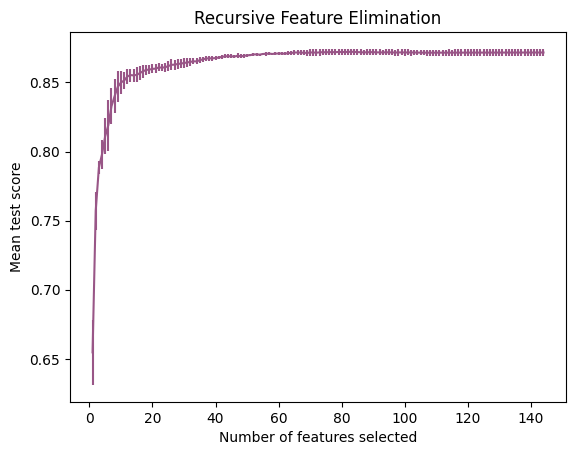

In [26]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()


In [27]:
X_train = X_resampled[:, rfecv.support_]
X_train

array([[ 0.44557008, -0.37756171, -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ],
       [ 0.57520148, -1.38314306, -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ],
       [-0.26740264, -0.12836483, -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ],
       ...,
       [ 1.1585428 , -0.70897073, -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ],
       [-0.72111256, -0.4771883 , -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ],
       [ 0.70483289,  0.20415885, -0.39220176, ..., -0.23602639,
        -0.15131607, -0.0615624 ]])

In [32]:

# outcome
y_test = test['hospital_death']

# Select only the features that were chosen by RFECV
X_train = X_resampled[:, rfecv.support_]
X_test = X_test_resampled[:, rfecv.support_]

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_resampled, y_res)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test_resampled)
y_pred_train = model.predict(X_resampled)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, y_test_resampled)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, y_res)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.799562909267433
Accuracy :  0.7995325422509888
Confusion Matrix:
[[4475 1143]
 [1087 4419]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5618
           1       0.79      0.80      0.80      5506

    accuracy                           0.80     11124
   macro avg       0.80      0.80      0.80     11124
weighted avg       0.80      0.80      0.80     11124

======== Test Set ==========
AUC :  0.7935399924372301
Accuracy :  0.7934551636209095
Confusion Matrix:
[[1887  506]
 [ 466 1847]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2393
           1       0.78      0.80      0.79      2313

    accuracy                           0.79      4706
   macro avg       0.79      0.79      0.79      4706
weighted avg       0.79      0.79      0.79      4706

